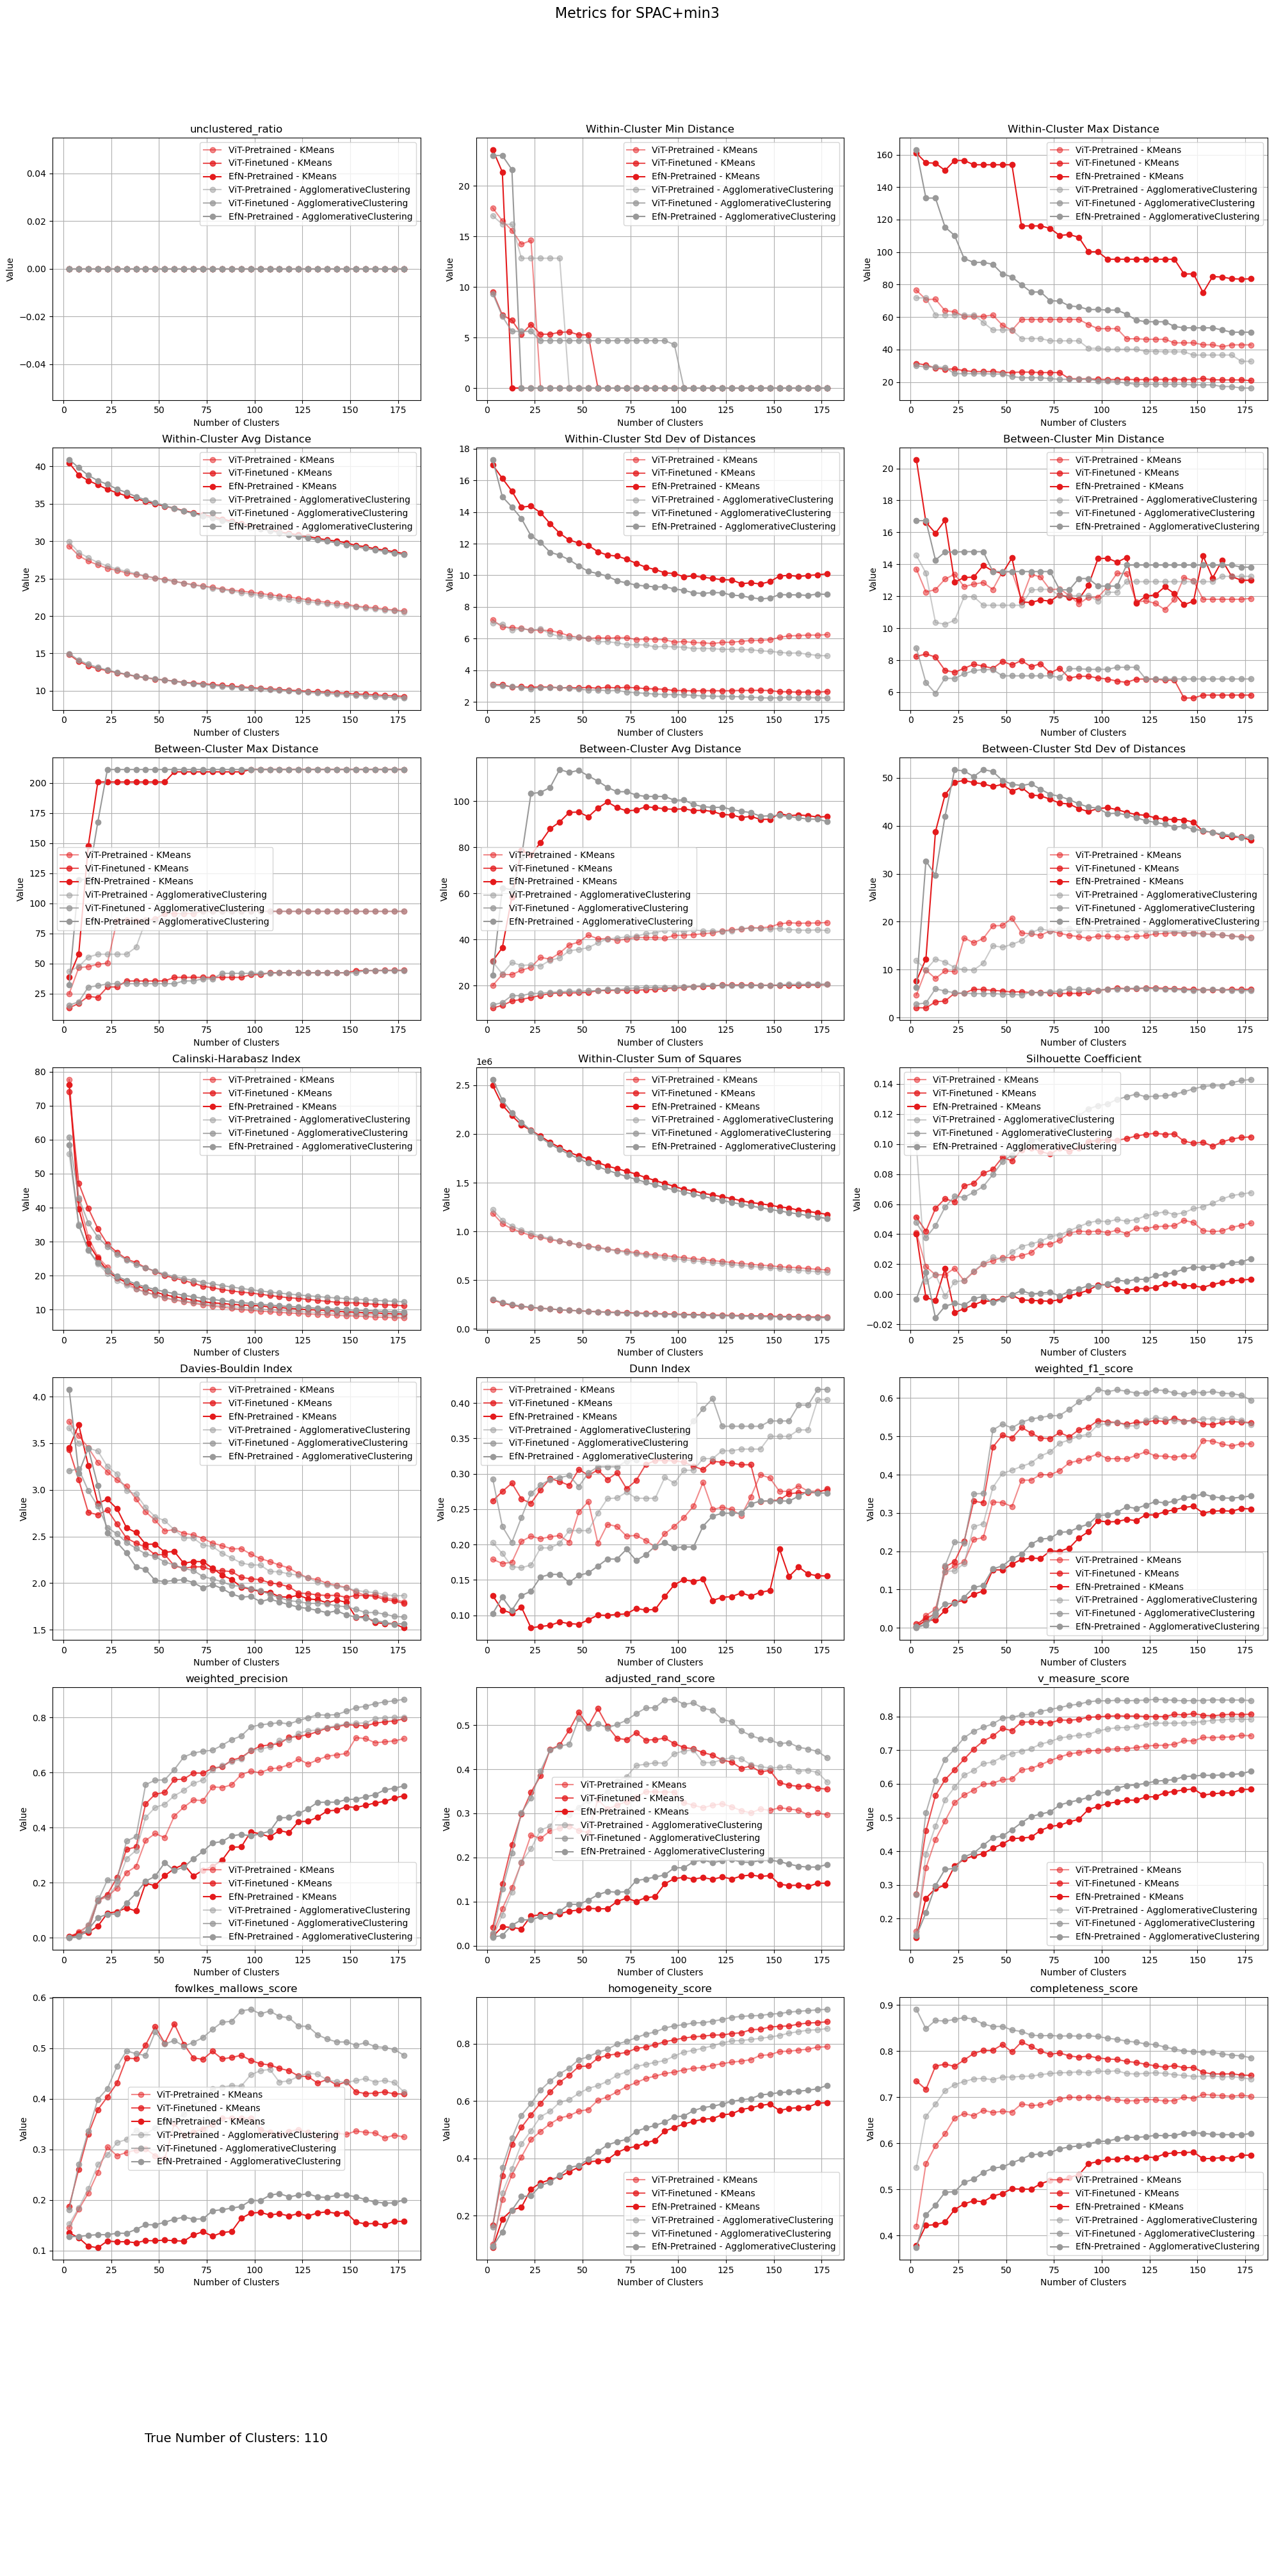

In [1]:
from gorillatracker.classification.clustering import (
    sweep_clustering_algorithms,
    configs,
    speed_level,
    visualize_alg_metrics,
    calculate_metrics,
    batch_visualize_alg_metrics,
    EXT_MERGED_DF,
    MERGED_DF,
    param_grid,
)
from gorillatracker.classification.metrics import formatted_names
import pandas as pd

metrics_df = pd.read_pickle("results3.pkl")
# visualize_alg_metrics(metrics_df, "SPAC", "ViT-Finetuned", "KMeans", formatted_names)
batch_visualize_alg_metrics(
    metrics_df,
    "SPAC+min3", # "Bristol", 
    ["ViT-Pretrained", "ViT-Finetuned", "EfN-Pretrained"],
    ["KMeans", "AgglomerativeClustering"],
    formatted_names,
)

In [2]:
print(metrics_df.columns)
print(metrics_df.dataset.unique())

Index(['unclustered_ratio', 'global_max_dist', 'global_min_dist',
       'global_avg_dist', 'global_std_dist', 'intra_min_dist',
       'intra_max_dist', 'intra_avg_dist', 'intra_std_dist', 'inter_min_dist',
       'inter_max_dist', 'inter_avg_dist', 'inter_std_dist',
       'calinski_harabasz_index', 'wcss', 'silhouette_coefficient',
       'davies_bouldin_index', 'dunn_index', 'weighted_f1_score',
       'weighted_precision', 'adjusted_rand_score', 'v_measure_score',
       'fowlkes_mallows_score', 'dataset', 'model', 'algorithm',
       'algorithm_params', 'n_clusters', 'n_true_clusters',
       'homogeneity_score', 'completeness_score'],
      dtype='object')
['Synthetic 200c 10n' 'Synthetic 20c 20n' 'SPAC' 'SPAC+min3'
 'SPAC+min3+max10' 'Bristol' 'Bristol+min25+max25']


In [7]:
import pandas as pd

def format_value(value):
    if pd.isna(value) or value == 'nan':
        return 'nan'
    elif isinstance(value, (int, float)):
        return f"{value:.3f}"
    else:
        return str(value)

def generate_first_graphic_data(df, dataset, model):
    df = df.copy()

    # First, filter the DataFrame
    spac_max3_vit_df = df[(df["dataset"] == dataset) & (df["model"] == model)]

    # List to store the summary of metrics
    metrics_summary = []

    # List of algorithms to check
    algorithms_to_check = spac_max3_vit_df["algorithm"].unique()

    # Iterate over each algorithm
    for algorithm in algorithms_to_check:
        # Filter DataFrame for the current algorithm
        algorithm_df = spac_max3_vit_df[spac_max3_vit_df["algorithm"] == algorithm]

        # Get the rows with max silhouette score, max dunn index, min davies-bouldin index, and max calinski-harabasz index
        max_silhouette_row = algorithm_df.loc[algorithm_df["silhouette_coefficient"].idxmax()]
        max_dunn_row = algorithm_df.loc[algorithm_df["dunn_index"].idxmax()]
        min_davies_bouldin_row = algorithm_df.loc[algorithm_df["davies_bouldin_index"].idxmin()]
        max_calinski_harabasz_row = algorithm_df.loc[algorithm_df["calinski_harabasz_index"].idxmax()]

        # Add rows to the metrics summary
        metrics_summary.extend(
            [
                [
                    "Silhouette Score (max)",
                    algorithm,
                    max_silhouette_row["adjusted_rand_score"],
                    max_silhouette_row["homogeneity_score"],
                    max_silhouette_row["completeness_score"],
                    max_silhouette_row["v_measure_score"],
                    max_silhouette_row["n_clusters"],
                ],
                [
                    "Dunn Index (max)",
                    algorithm,
                    max_dunn_row["adjusted_rand_score"],
                    max_dunn_row["homogeneity_score"],
                    max_dunn_row["completeness_score"],
                    max_dunn_row["v_measure_score"],
                    max_dunn_row["n_clusters"],
                ],
                [
                    "Davies-Bouldin Index (min)",
                    algorithm,
                    min_davies_bouldin_row["adjusted_rand_score"],
                    min_davies_bouldin_row["homogeneity_score"],
                    min_davies_bouldin_row["completeness_score"],
                    min_davies_bouldin_row["v_measure_score"],
                    min_davies_bouldin_row["n_clusters"],
                ],
                [
                    "Calinski-Harabasz Index (max)",
                    algorithm,
                    max_calinski_harabasz_row["adjusted_rand_score"],
                    max_calinski_harabasz_row["homogeneity_score"],
                    max_calinski_harabasz_row["completeness_score"],
                    max_calinski_harabasz_row["v_measure_score"],
                    max_calinski_harabasz_row["n_clusters"],
                ],
            ]
        )

    # Convert to DataFrame for easy display
    return pd.DataFrame(
        metrics_summary,
        columns=[
            "Approach",
            "Algorithm",
            "Rand Score",
            "Homogeneity",
            "Completeness",
            "V-Measure",
            "n_clusters",
        ],
    )

def generate_latex_table(df, dataset, model):
    latex_code = [
        r"\begin{table}[H]",
        r"    \centering",
        r"    \resizebox{\textwidth}{!}{%",
        r"    \begin{tabular}{llccccc}",
        r"    \toprule",
        r"    \multicolumn{2}{l}{Approaches} & \multicolumn{5}{c}{Metrics} \\",
        r"     \cmidrule(lr){3-7}",
        r"    & & ARI & Homogeneity & Completeness & V-Measure & Clusters Found \\",
        r"    \midrule",
    ]

    for approach in df['Approach'].unique():
        latex_code.append(f"    \multicolumn{{7}}{{l}}{{\\textbf{{{approach}}}}} \\\\")
        group = df[df['Approach'] == approach]
        for _, row in group.iterrows():
            formatted_values = [
                format_value(row['Rand Score']),
                format_value(row['Homogeneity']),
                format_value(row['Completeness']),
                format_value(row['V-Measure']),
                str(row['n_clusters'])
            ]
            latex_code.append(f"    & {row['Algorithm']} & {' & '.join(formatted_values)} \\\\")
        if approach != df['Approach'].unique()[-1]:
            latex_code.append(r"    \midrule")

    latex_code.extend(
        [
            r"    \bottomrule",
            r"    \end{tabular}%",
            r"    }",
            r"    \caption{Comparison of Clustering Approaches and Algorithms across Various Metrics. Dataset is " + dataset + " and Model is " + model + "}",
            r"    \label{tab:clustering-metrics}",
            r"\end{table}",
        ]
    )

    return "\n".join(latex_code)

dataset = "SPAC+min3"
model = "ViT-Finetuned"
metrics_summary_df = generate_first_graphic_data(metrics_df, dataset, model)
print(generate_latex_table(metrics_summary_df, dataset, model))

\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{llccccc}
    \toprule
    \multicolumn{2}{l}{Approaches} & \multicolumn{5}{c}{Metrics} \\
     \cmidrule(lr){3-7}
    & & RAND & Homogeneity & Completeness & V-Measure & Clusters Found \\
    \midrule
    \multicolumn{7}{l}{\textbf{Silhouette Score (max)}} \\
    & KMeans & 0.416 & 0.836 & 0.768 & 0.800 & 128 \\
    & AgglomerativeClustering & 0.426 & 0.920 & 0.786 & 0.848 & 178 \\
    & HDBSCAN & 0.047 & nan & nan & 0.710 & 290 \\
    \midrule
    \multicolumn{7}{l}{\textbf{Dunn Index (max)}} \\
    & KMeans & 0.467 & 0.797 & 0.787 & 0.792 & 88 \\
    & AgglomerativeClustering & 0.440 & 0.918 & 0.790 & 0.849 & 173 \\
    & HDBSCAN & 0.047 & nan & nan & 0.710 & 290 \\
    \midrule
    \multicolumn{7}{l}{\textbf{Davies-Bouldin Index (min)}} \\
    & KMeans & 0.355 & 0.877 & 0.747 & 0.807 & 178 \\
    & AgglomerativeClustering & 0.426 & 0.920 & 0.786 & 0.848 & 178 \\
    & HDBSCAN & 0.047 & nan & nan & 0.

Processing configurations: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s]

Processing SPAC+min3 ViT-Finetuned KMeans
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 3}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 8}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 13}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 18}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 23}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 28}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 33}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 38}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 43}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 48}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 53}
Loading cached result for SPAC+min3, ViT-Finetuned, KMeans, {'n_clusters': 58}
Loading cach

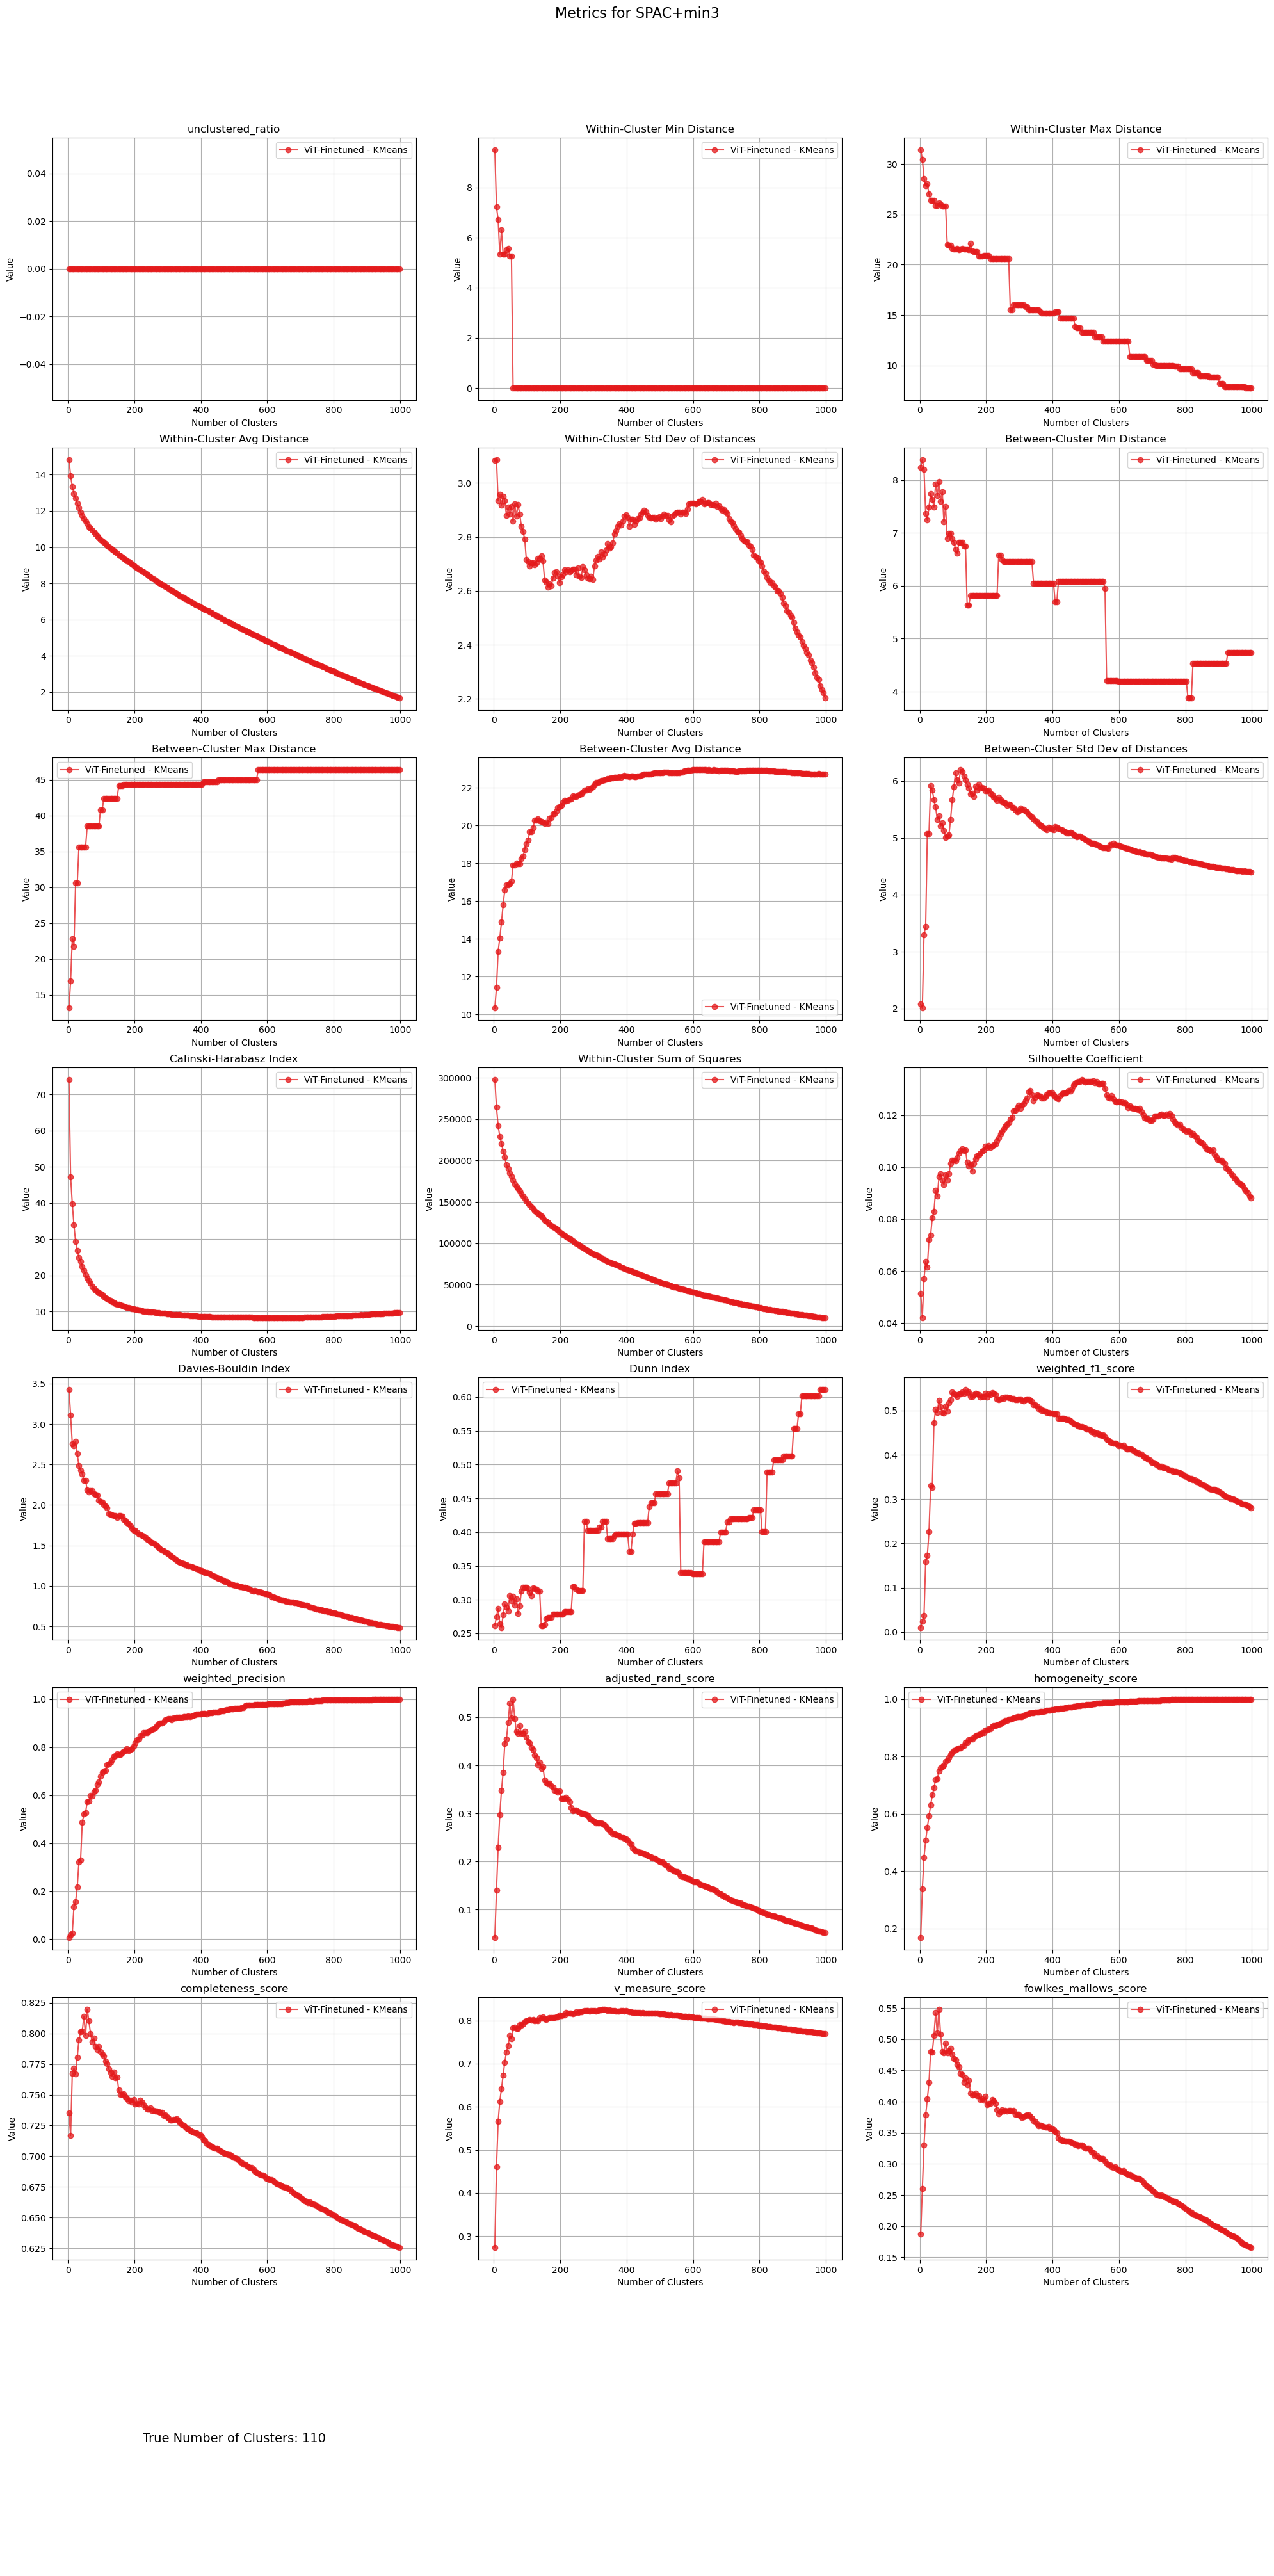

In [ ]:
# NOTE(liamvdv): We're investiagting the performance of silouhette score -- maybe we didn't push the clustering far enough.
from gorillatracker.classification.clustering import (
    sweep_clustering_algorithms,
    configs,
    speed_level,
    visualize_alg_metrics,
    calculate_metrics,
    batch_visualize_alg_metrics,
    EXT_MERGED_DF,
    MERGED_DF,
    param_grid,speed
)
from gorillatracker.classification.metrics import formatted_names
import pandas as pd

results2_df = sweep_clustering_algorithms(EXT_MERGED_DF, [("SPAC+min3", "ViT-Finetuned", "KMeans", param_grid({"n_clusters": range(3, 1000, speed(1, 5, 20))}))], cache_dir="./cache_cluster_sweep")
# visualize_alg_metrics(metrics_df, "SPAC", "ViT-Finetuned", "KMeans", formatted_names)
batch_visualize_alg_metrics(
    results2_df,
    "SPAC+min3",
    ["ViT-Pretrained", "ViT-Finetuned", "EfN-Pretrained"],
    ["KMeans", "AgglomerativeClustering"],
    formatted_names,
)

In [ ]:
# run tsne on the data
# from sklearn.manifold import TSNE
# TSNE()
m = EXT_MERGED_DF 
m[(m["dataset"] == "SPAC+min3") & (m["model"] == "ViT-Finetuned")].count()

id              1297
embedding       1297
label           1297
label_string    1297
input           1297
dataset         1297
model           1297
index           1297
dtype: int64